In [1]:
import os

!pip install wget
if not os.path.exists('thinkdsp.py'):
    !python -m wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/thinkdsp.py

import numpy as np
PI2 = np.pi * 2

import matplotlib.pyplot as plt

from thinkdsp import decorate
from thinkdsp import UncorrelatedGaussianNoise

# Упражнение 6.1
В этой главе утверждается, что analyze1 требует времени пропорционально n^3, а analyze2 — пропорционально n^2. Убедитесь в этом, запуская их с несколькими разными массивами и засекая время рабо ты. В блокнотах Jupyter можно использовать «волшебную команду» %timeit.

Если печатать зависимость времени работы от размера на логарифмической шкале, то получится прямая линия с уклоном 3 для analyze1 и с уклоном 2 для analyze2.

Также стоит поупражняться с dct_iv и scipy.fftpack.dct.

In [2]:
def analyze1(ys, fs, ts):
    args = np.outer(ts, fs)
    M = np.cos(PI2 * args)
    amps = np.linalg.solve(M, ys)
    return amps

def analyze2(ys, fs, ts):
    args = np.outer(ts, fs)
    M = np.cos(PI2 * args)
    amps = M.dot(ys) / 2
    return amps

def dct_iv(ys):
    N = len(ys)
    ts = (0.5 + np.arange(N)) / N
    fs = (0.5 + np.arange(N)) / 2
    args = np.outer(ts, fs)
    M = np.cos(PI2 * args)
    amps = np.dot(M, ys) / 2
    return amps

signal = UncorrelatedGaussianNoise()
wave = signal.make_wave(duration=1.0, framerate=16384)
wave.ys.shape

(16384,)

Возьмём размеры массива как степени тройки.

In [3]:
ns = 3 ** np.arange(3,9)
ns

array([  27,   81,  243,  729, 2187, 6561], dtype=int32)

Теперь посмотрим зависимость времени от размера матрицы, должна быть кубическая зависимость

In [4]:
best_analyze1 = []
for n in ns:
    ts = (0.5 + np.arange(n)) / n
    freqs = (0.5 + np.arange(n)) / 2
    ys = wave.ys[:n]
    best =  %timeit -r1 -o analyze1(ys,freqs,ts)
    best_analyze1.append(best.best)
best_analyze1

54.4 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10000 loops each)
193 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10000 loops each)
1.39 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1000 loops each)
20.8 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
281 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
3.58 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


[5.444658000000002e-05,
 0.0001929641700000001,
 0.0013943189999999993,
 0.02076293800000002,
 0.28120919999999927,
 3.5831503]

In [5]:
best_analyze2 = []
for n in ns:
    ts = (0.5 + np.arange(n)) / n
    freqs = (0.5 + np.arange(n)) / 2
    ys = wave.ys[:n]
    best =  %timeit -r1 -o analyze2(ys,freqs,ts)
    best_analyze2.append(best.best)
best_analyze2

25.7 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10000 loops each)
111 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10000 loops each)
995 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1000 loops each)
10.9 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
109 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
914 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


[2.5683749999999962e-05,
 0.0001110888899999999,
 0.0009953758000000015,
 0.010889257999999983,
 0.10930018999999973,
 0.9138737999999975]

In [6]:
import scipy.fftpack

best_dct = []
for n in ns:
    ys = wave.ys[:n]
    best =  %timeit -r1 -o scipy.fftpack.dct(ys, type=3)
    best_dct.append(best.best)
best_dct

11.4 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 100000 loops each)
11.3 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 100000 loops each)
13 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 100000 loops each)
17.1 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 100000 loops each)
32.1 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10000 loops each)
79 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10000 loops each)


[1.1433560999999983e-05,
 1.1345004000000003e-05,
 1.3047617999999944e-05,
 1.7110825000000035e-05,
 3.210863999999987e-05,
 7.900464999999955e-05]

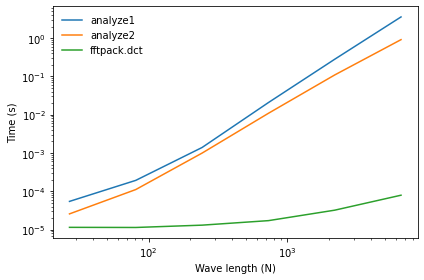

In [7]:
plt.plot(ns, best_analyze1, label='analyze1')
plt.plot(ns, best_analyze2, label='analyze2')
plt.plot(ns, best_dct, label='fftpack.dct')
loglog = dict(xscale='log', yscale='log')
decorate(xlabel='Wave length (N)', ylabel='Time (s)', **loglog)

In [8]:
from scipy.stats import linregress

linregress(np.log(ns),np.log(best_analyze1))

LinregressResult(slope=2.081235383318656, intercept=-17.377863461660546, rvalue=0.9936207525969387, pvalue=6.0912395053786094e-05, stderr=0.11810724719297049, intercept_stderr=0.7472603049525954)

In [9]:
linregress(np.log(ns),np.log(best_analyze2))

LinregressResult(slope=1.9626038884534938, intercept=-17.427260881192836, rvalue=0.9979364524452048, pvalue=6.382949237836225e-06, stderr=0.0631390217390496, intercept_stderr=0.3994783195822288)

In [10]:
linregress(np.log(ns),np.log(best_dct))

LinregressResult(slope=0.33956909781780686, intercept=-12.848598667481996, rvalue=0.9087571181646507, pvalue=0.012108084712196014, stderr=0.07796957575078489, intercept_stderr=0.49331070139465366)

Получили что, метод analyze1 пропорционален квадрату а не кубу.

# Упражнение 6.2

Одно из основных применений ДКП - это сжатие звука и изображений. В простейшей форме ДКП при сжатии работает следующим образом:

1. Разбивает длинный сигнал на сегменты.

2. Вычисляет ДКП каждого сегмента.

3. Определяет частотные компоненты с такой амплитудой, что их не слышно, и удаляет их, сохраняя только оставшиеся частоты и амплитуды.

4. При воспроизведении сигнала загружает частоты и амплитуды каждого сегмента и применяет обратное ДКП.

Реализуйте версию этого алгоритма и примените его для записи музыки или речи. Сколько компонент можно удалить до того, как разница станет заметной?

Для того, чтобы этот метод стал практичным, нужен способ хранения прореженного массива, то есть массива, где большинство элементов равно нулю. NumPy (SciPy)дает несколько способов работы с прореженными массивами; о них можно прочитать на веб-странице http://docs.scipy.org/doc/scipy/reference/sparse.html

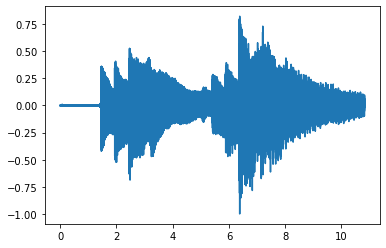

In [11]:
from thinkdsp import read_wave

if not os.path.exists('electric-guitar-phrase.wav'):
    !python -m wget https://github.com/timatifey/spbstu-telecom-labs-2022/raw/main/chap06/electric-guitar-phrase.wav

wave = read_wave('electric-guitar-phrase.wav')
wave.plot()
wave.make_audio()

Возьмем сегмент для сжатия

In [12]:
segment = wave.segment(start = 3.25,duration = 1.0)
segment.normalize()
segment.make_audio()

Используем DFT

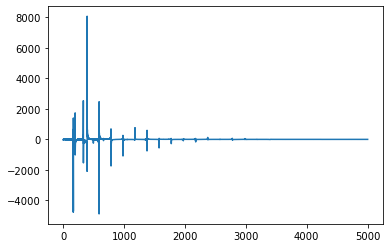

In [13]:
dct = segment.make_dct()
dct.plot(high = 5000)

In [14]:
def filtering(dct,limit = 0):
    for i, amp in enumerate(dct.amps):
        if np.abs(amp) < limit:
              dct.hs[i] = 0

In [15]:
filtering(dct,1000)

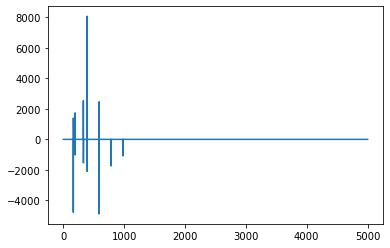

In [16]:
dct.plot(high = 5000)

In [17]:
dct = segment.make_dct()
filtering(dct,150)

Можно играться со значением лимита, чтобы подобрать запись более похожую на оригинал

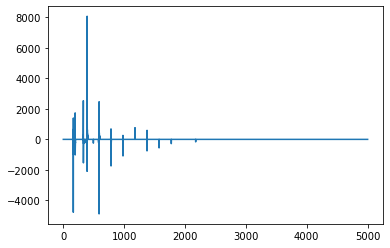

In [18]:
dct.plot(high = 5000)
dct.make_wave().make_audio()

Получили сжатую запись

# Упражнение 6.3

В репозитории этой книги есть блокнот Jupyter под названием phase.ipnyb, в котором исследуется влияние фазы на восприятие звука. Прочтите этот блокнот и «погоняйте» примеры. Выберите иной сегмент звука и повторите эксперименты. Можно ли найти некие общие соотношения в фазовой структуре звука и его восприятии?

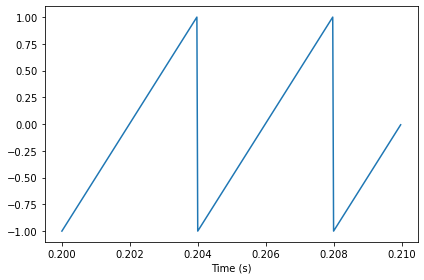

In [19]:
from thinkdsp import SawtoothSignal

signal = SawtoothSignal(freq=250, offset=0)
wave = signal.make_wave(duration=0.5, framerate=40000)
wave.segment(start=0.2,duration=0.01).plot()
decorate(xlabel='Time (s)')
wave.make_audio()

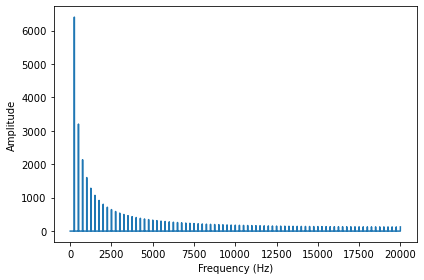

In [20]:
spectrum = wave.make_spectrum()
spectrum.plot()
decorate(xlabel='Frequency (Hz)',
         ylabel='Amplitude')

In [21]:
def plot_angle(spectrum, thresh=1):
    angles = spectrum.angles
    angles[spectrum.amps < thresh] = np.nan
    plt.plot(spectrum.fs, angles, 'x')
    decorate(xlabel='Frequency (Hz)', 
             ylabel='Phase (radian)')

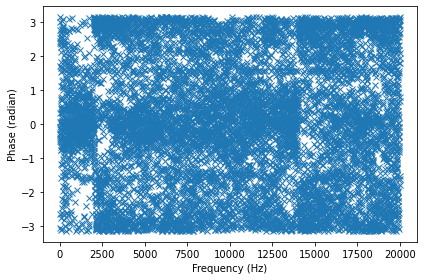

In [22]:
plot_angle(spectrum, thresh=0)

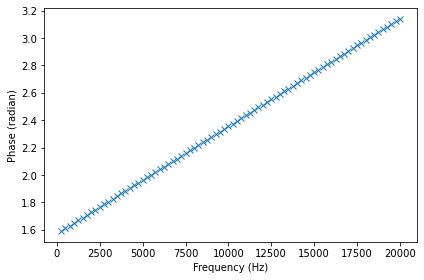

In [23]:
plot_angle(spectrum, thresh=1)

In [24]:
def plot_three(spectrum, thresh=1):
    """Plot amplitude, phase, and waveform.

    spectrum: Spectrum object
    thresh: threshold passed to plot_angle
    """
    plt.figure(figsize=(10, 4))
    plt.subplot(1,3,1)
    spectrum.plot()
    plt.subplot(1,3,2)
    plot_angle(spectrum, thresh=thresh)
    plt.subplot(1,3,3)
    wave = spectrum.make_wave()
    wave.unbias()
    wave.normalize()
    wave.segment(duration=0.01).plot()
    display(wave.make_audio())

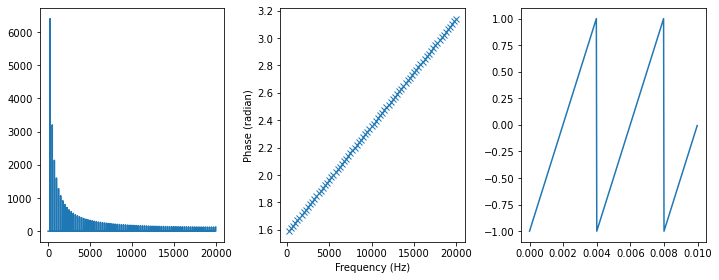

In [25]:
plot_three(spectrum)

Теперь меняем сигнал:

In [26]:
def rotate_angle(spectrum, offset):
    res = spectrum.copy()
    res.hs *= np.exp(1j * offset)
    return res

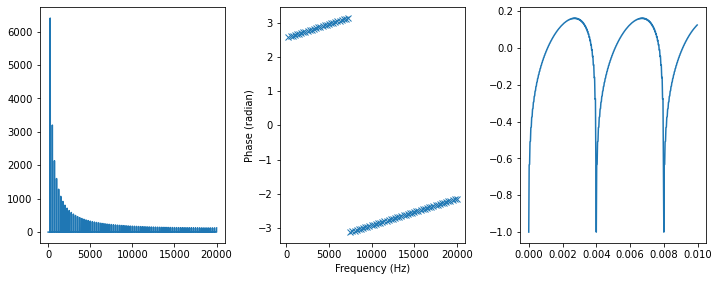

In [27]:
spectrum2 = rotate_angle(spectrum, 1)
plot_three(spectrum2)

In [28]:
def zero_angle(spectrum):
    res = spectrum.copy()
    res.hs = res.amps
    return res

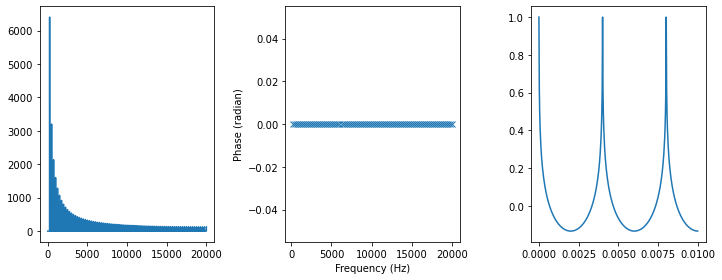

In [29]:
spectrum3 = zero_angle(spectrum2)
plot_three(spectrum3)

Сигнал не меняется

In [30]:
PI2 = np.pi * 2

def random_angle(spectrum):
    res = spectrum.copy()
    angles = np.random.uniform(0, PI2, len(spectrum))
    res.hs *= np.exp(1j * angles)
    return res

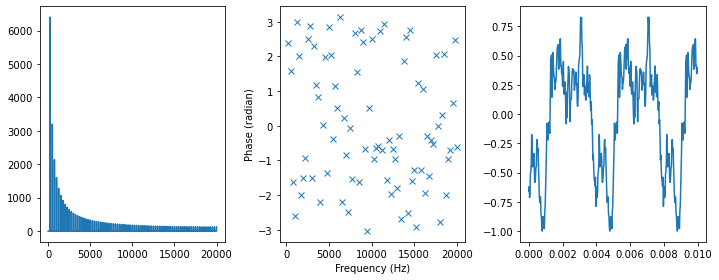

In [31]:
spectrum4 = random_angle(spectrum2)
plot_three(spectrum4)

Звук стал более "электронным".

Для звуков с простой гармонической структурой мы не слышим измнения в фазовой структуре, при условии что гармоническая структура неизменна.